In [1]:
from wrapper import *
import MahjongPy as mp
import os
import time
import logging
import warnings

import numpy as np
import scipy.io as sio
import torch
import matplotlib.pyplot as plt


from models import VLOG

In [2]:

UNICODE_TILES = """
    🀇 🀈 🀉 🀊 🀋 🀌 🀍 🀎 🀏 
    🀙 🀚 🀛 🀜 🀝 🀞 🀟 🀠 🀡
    🀐 🀑 🀒 🀓 🀔 🀕 🀖 🀗 🀘
    🀀 🀁 🀂 🀃
    🀆 🀅 🀄
""".split()

EXPLAINS = UNICODE_TILES + ["Chi-Left", "Chi-Middle", "Chi-Right", "Pon", "An-Kan",
           "Min-Kan", "Add-Kan", "Riichi", "Ron", "Tsumo", "Push 99", "Pass"]


def to_unicode_tails(tiles, sort=True):
    unicode_tail_string = ""
    if sort:
        tiles = np.sort(np.array(tiles))

    for tile in tiles:
        unicode_tail_string = unicode_tail_string + UNICODE_TILES[int(tile / 4)]

    return unicode_tail_string

In [3]:
env_test = EnvMahjong3()
max_steps = 1000

In [4]:
agent_test = torch.load("./vlog_offlinemj_20210724/search_envid_1_beta_0_alpha_1_kldt_-1_cqla_100/data/mahjong_VLOG_DDQN_0.model")

In [5]:
agents_test = [agent_test, None, None, None]

In [6]:
full_obs = False

==================Game 0=================
This game already ended!
~~~~~~~~~~~~Result:  [0.0, 0.0, 0.0, 0.0]


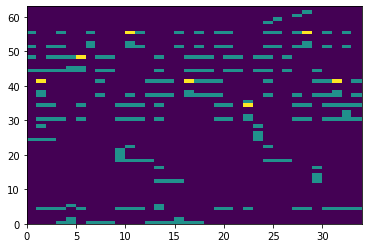

==================Game 1=================
This game already ended!
~~~~~~~~~~~~Result:  [0.0, 0.0, 0.0, 0.0]


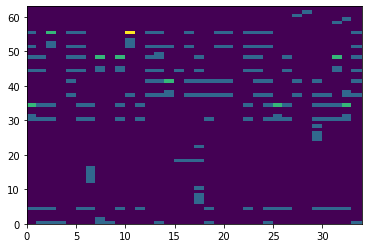

==================Game 2=================
This game already ended!
~~~~~~~~~~~~Result:  [0.0, 0.0, 0.0, 0.0]


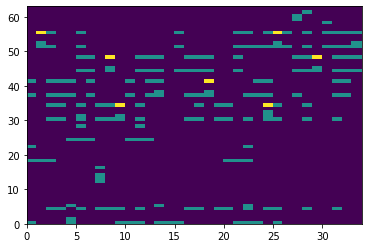

In [ ]:
EpiTestRet = 0
steps_taken = 0

for game in range(100):
    print("==========================================")
    print("==================Game {}=================".format(game))
    print("==========================================")
    # reset each episode
    sp = env_test.reset(0, 'east')

    for tt in range(max_steps):
        
        curr_pid = env_test.get_curr_player_id()
        valid_actions = env_test.get_valid_actions(nhot=False)

        if curr_pid != 0:
            a = valid_actions[np.random.randint(len(valid_actions))]
        
        if curr_pid == 0:
            action_mask = env_test.get_valid_actions(nhot=True)
            if not full_obs:
                a = agents_test[curr_pid].select(sp, action_mask, greedy=True)
            else:
                a = agents_test[curr_pid].select(env_test.get_full_obs(env_test.get_curr_player_id()), action_mask, greedy=True)

        if curr_pid == 0 and len(valid_actions) > 1 and a > 40 and a < 45:
            print("-------------- Step {}, player {} ----------------".format(tt, curr_pid))
            print(env_test.Phases[env_test.t.get_phase()], "Recent Tile:", to_unicode_tails([env_test.latest_tile]))
            side_tiles_0 = [st[0] for st in env_test.side_tiles[curr_pid]]
            print("手牌: ", to_unicode_tails(env_test.hand_tiles[curr_pid]),
                  "； 副露：", to_unicode_tails(side_tiles_0))
            if a < 34:
                agent_selection_str = UNICODE_TILES[a]
            else:
                agent_selection_str = EXPLAINS[a]

            print("Agent选择打: ", agent_selection_str)
        
        sp, r, done, _ = env_test.step(curr_pid, a)

        steps_taken += 1

        if done:
            payoffs = env_test.get_payoffs()
            EpiTestRet += payoffs[0]
            
            print("~~~~~~~~~~~~Result: ", payoffs)
            plt.pcolor(sp)
            plt.show()
            
            break

In [ ]:
a

In [ ]:
env_test.can_riichi_tiles_id

In [ ]:
for act in env_test.t.get_self_actions():
    print(act.action)
    print(int(act.correspond_tiles[0].tile))

In [ ]:
env_test.riichi_tile_id

In [ ]:
int(env_test.t.get_selected_action_tile().tile)

In [ ]:
env_test.t.get_response_actions()[0].action

In [ ]:
env_test.t.players[curr_pid].hand.__len__()

In [ ]:
env_test.Phases[env_test.t.get_phase()]

In [ ]:
env_test.hand_tiles[curr_pid]

In [ ]:
env_test.can_riichi

In [ ]:
env_test.t.get_self_actions()[0].action

In [ ]:
a = set([1,2,3,4,4])

In [ ]:
list(a)

In [ ]:
mp.Action.Kakan